# Figures for WP spread

In [1]:
%load_ext autoreload

In [2]:
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import xarray as xr
from tqdm import tqdm
from pathlib import Path

from LAPM.discrete_linear_autonomous_pool_model import DiscreteLinearAutonomousPoolModel as DLAPM
from CompartmentalSystems.discrete_model_run import DiscreteModelRun as DMR
import CompartmentalSystems.helpers_reservoir as hr

from BFCPM import utils
from BFCPM import DATA_PATH, FIGS_PATH, Q_, zeta_dw
from BFCPM.trees.single_tree_allocation import allometries
from BFCPM.trees.single_tree_params import species_params

%autoreload 2

In [3]:
# set plotting properties

mpl.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 16
MEDIUM_SIZE = 17
#BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load available simulations and sort them

In [4]:
all_sims_path = DATA_PATH.joinpath("simulations")

#sim_date = "2023-05-20" # differenct emergency strategies
#sim_date = "2023-06-08" # corrected wood density
#sim_date = "2023-06-19" # automatic thinning stand to SBA=18 on emergency cutting
#sim_date = "2023-07-26" # publication
sim_date = "2023-11-23" # WP spread

# path to place the figures for the publication
pub_figs_path = FIGS_PATH.joinpath(f"{sim_date}")
pub_figs_path.mkdir(exist_ok=True, parents=True)

print(pub_figs_path)

spinup_length = 160

/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-11-23


In [5]:
WP_types = ["WP_short_only", "WP_both", "WP_long_only"]

In [6]:
# reconcile filenames and simulation names
eligible_sim_names = {
    "mixed-aged_pine_N1500": "mixed-aged_pine",
    "even-aged_pine": "even-aged_pine",
    "even-aged_spruce": "even-aged_spruce",
    "even-aged_mixed": "even-aged_mixed",
}

In [7]:
sims_data = dict()
for WP_type in WP_types:
    dss = dict()

    sim_cohort_path = all_sims_path.joinpath(f"{sim_date}_{WP_type}")
    sim_names = list()

    for p in sim_cohort_path.iterdir():
        if (p.suffix == ".nc") and (p.stem.find("_long") == -1):
            file_sim_name = p.stem
            if file_sim_name in eligible_sim_names.keys():
                sim_name = eligible_sim_names[file_sim_name]
                print(WP_type, len(sim_names), sim_name)
                sim_names.append(sim_name)
                dss[sim_name] = xr.open_dataset(str(p))
        
    sim_data = dict()
    sim_data["dss"] = dss

    sims_data[WP_type] = sim_data

WP_short_only 0 even-aged_mixed
WP_short_only 1 even-aged_pine
WP_short_only 2 even-aged_spruce
WP_short_only 3 mixed-aged_pine
WP_both 0 even-aged_mixed
WP_both 1 even-aged_pine
WP_both 2 even-aged_spruce
WP_both 3 mixed-aged_pine
WP_long_only 0 even-aged_mixed
WP_long_only 1 even-aged_pine
WP_long_only 2 even-aged_spruce
WP_long_only 3 mixed-aged_pine


In [8]:
sim_names = [sim_names[k] for k in [3, 1, 2, 0]]

nr_spinup_trees = 4
[print(f"{k}: {sim_name}") for k, sim_name in enumerate(sim_names)];

0: mixed-aged_pine
1: even-aged_pine
2: even-aged_spruce
3: even-aged_mixed


## Carbon sequestration and climate change mitigation

In [9]:
CS_datas = list()
for sim_name in sim_names:
    l = list()
    for WP_type in WP_types:
        ds = sims_data[WP_type]["dss"][sim_name]
        CS = ds.CS_through_time#.isel(time=-1)
        CS = CS.data # gC/m^2 yr, CS.attrs["units"]).to("yr*kgC/m^2")
        l.append(CS)
        
    CS_datas.append(l)
    
CS_datas = Q_(np.array(CS_datas).transpose(), "yr*gC/m^2").to("yr*kgC/m^2")
CS_datas.shape

(81, 3, 4)

In [10]:
CB_datas = list()

#ti = -2

for sim_name in sim_names:
    l = list()
    for WP_type in WP_types:
        ds = sims_data[WP_type]["dss"][sim_name]
        x0 = ds.stocks.isel(time=0).sum(dim=["entity", "pool"])
        CB = ds.stocks.sum(dim=["entity", "pool"]) - x0
        CB = CB.data # gC/m^2
        l.append(CB)
      
    CB_datas.append(l)
    
CB_datas = Q_(np.array(CB_datas).transpose(), "gC/m^2").to("kgC/m^2")
CB_datas.shape

(81, 3, 4)

In [11]:
cum_stocks_datas = list()
for sim_name in sim_names:
    l = list()
    for WP_type in WP_types:
        ds = sims_data[WP_type]["dss"][sim_name]
        cum_stocks = ds.stocks.sum(dim=["entity", "pool"]).cumsum(dim="time")
        cum_stocks = cum_stocks.data # gC/m^2 yr, ds.stocks.attrs["units"]) * Q_("1 yr")).to("kgC/m^2 yr")
        l.append(cum_stocks)

    cum_stocks_datas.append(l)
    
cum_stocks_datas = Q_(np.array(cum_stocks_datas).transpose(), "yr*gC/m^2").to("yr*kgC/m^2")
cum_stocks_datas.shape

(81, 3, 4)

In [12]:
yield_datas = list()
for sim_name in sim_names:
    l = list()
    for WP_type in WP_types:
        ds = sims_data[WP_type]["dss"][sim_name]
        WP_cum = ds.internal_fluxes.sel(entity_to="wood_product").sum(dim=["pool_to", "entity_from", "pool_from"]).cumsum(dim="time")
        l.append(WP_cum)
        
    yield_datas.append(l)

yield_datas = Q_(np.array(yield_datas).transpose(), "gC/m^2").to("kgC/m^2")
yield_datas.shape

(81, 3, 4)

In [13]:
# identify the color codes:

#colors = dict()
#for sim_name in sim_names:
#    l = plt.plot([0, 1], [0, 1])
#    colors[sim_name] = l[0].get_c()
#
#print(colors)

PosixPath('/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-11-23/WP_spread_1.png')

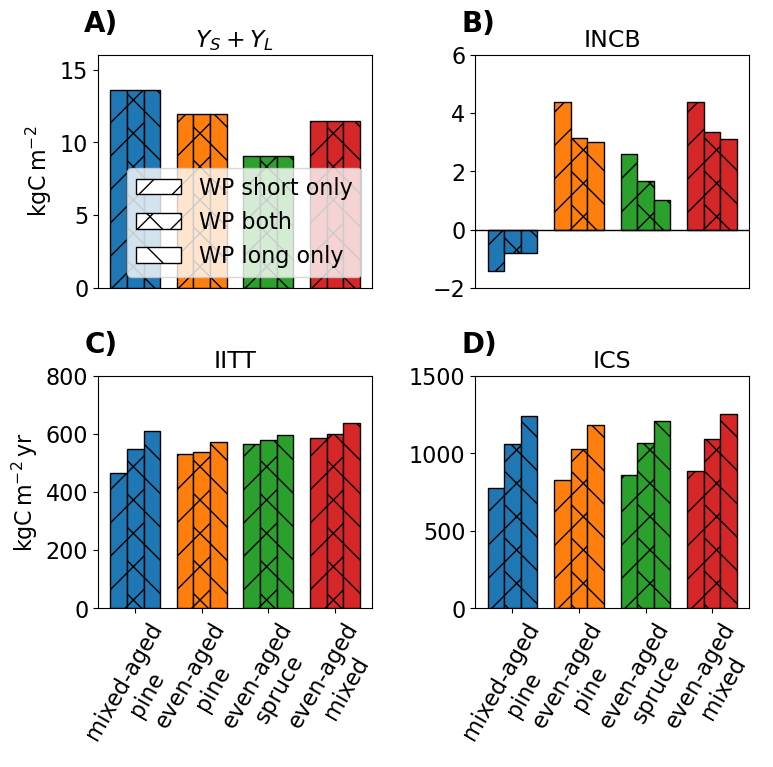

In [14]:
fig, axes_ = plt.subplots(figsize=(4*2, 4*2), ncols=2, nrows=2)
panel_names = iter(string.ascii_uppercase[:4])
axes = iter(axes_.flatten())

labels = [sim_name.replace("_", " ") for sim_name in sim_names]
colors = {
    'mixed-aged_pine': '#1f77b4',
    'even-aged_pine': '#ff7f0e',
    'even-aged_spruce': '#2ca02c',
    'even-aged_mixed': '#d62728'
}
hatches = ["/", "x", "\\"]
width = 0.25
x = np.arange(len(sim_names))

ax = next(axes)
panel_name = next(panel_names)
multiplier = 0

for WP_nr, WP_type in enumerate(WP_types):
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        yield_datas[-1, WP_nr, :], 
        width,
        color=[colors[sim_name] for sim_name in sim_names],
        edgecolor="black", hatch=hatches[WP_nr],
        label=WP_type.replace("_", " ")
    )
    multiplier += 1
                   
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_ylim([0, 16])
ax.legend(loc=4)
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
#ax.set_title("Total cumulative wood-product yield C ($Y_S+Y_L$)")
ax.set_title("$Y_S+Y_L$")
ax.set_xticks([])
ax.set_xticklabels("")

ax = next(axes)
panel_name = next(panel_names)
multiplier = 0

for WP_nr, WP_type in enumerate(WP_types):
    offset = width * multiplier
#    rects = ax.bar(x + offset, CB_datas[-1, WP_nr, :], width, label=WP_type.replace("_", " "))
    rects = ax.bar(
        x + offset,
        CB_datas[-1, WP_nr, :], 
        width,
        color=[colors[sim_name] for sim_name in sim_names],
        edgecolor="black", hatch=hatches[WP_nr],
        label=WP_type.replace("_", " ")
    )
    multiplier += 1

#ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_ylabel("")
ax.set_ylim([-2, 6])
#ax.set_title("Integrated Net Carbon Balance (INCB)")
ax.set_title("INCB")
ax.axhline(0, c="black", lw=1)
ax.set_xticks([])
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

ax = next(axes)
panel_name = next(panel_names)
multiplier = 0

for WP_nr, WP_type in enumerate(WP_types):
    offset = width * multiplier
#    rects = ax.bar(x + offset, CS_datas[-1, WP_nr, :], width, label=WP_type.replace("_", " "))
    rects = ax.bar(
        x + offset,
        CS_datas[-1, WP_nr, :], 
        width,
        color=[colors[sim_name] for sim_name in sim_names],
        edgecolor="black", hatch=hatches[WP_nr],
        label=WP_type.replace("_", " ")
    )
    multiplier += 1

ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_ylim([0, 800])
#ax.set_title("Integrated Inputs Transit Time (IITT)")
ax.set_title("IITT")
ax.set_xticks([])
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

ax = next(axes)
panel_name = next(panel_names)
multiplier = 0

for WP_nr, WP_type in enumerate(WP_types):
    offset = width * multiplier
#    rects = ax.bar(x + offset, cum_stocks_datas[-1, WP_nr, :], width, label=WP_type.replace("_", " "))
    rects = ax.bar(
        x + offset,
        cum_stocks_datas[-1, WP_nr, :], 
        width,
        color=[colors[sim_name] for sim_name in sim_names],
        edgecolor="black", hatch=hatches[WP_nr],
        label=WP_type.replace("_", " ")
    )
    multiplier += 1

#ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_ylabel("")
ax.set_ylim([0, 1500])
#ax.set_title("Integrated Carbon Stocks (ICS)")
ax.set_title("ICS")
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


for ax in axes_[1, :]:
    xlabels = [sim_name.replace("_", " ") for sim_name in sim_names]
    xlabels = ["mixed-aged\npine", "even-aged\npine", "even-aged\nspruce", "even-aged\nmixed"]
    ax.set_xticks(x + width, xlabels)

    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

leg = axes_[0, 0].get_legend()
for lh in leg.legend_handles:
    lh.set_color("white")
    lh.set_edgecolor("black")

fig.tight_layout()

filepath = pub_figs_path.joinpath("WP_spread_1.png")
fig.savefig(filepath, dpi=500)
filepath

PosixPath('/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-11-23/WP_spread_1_v2.png')

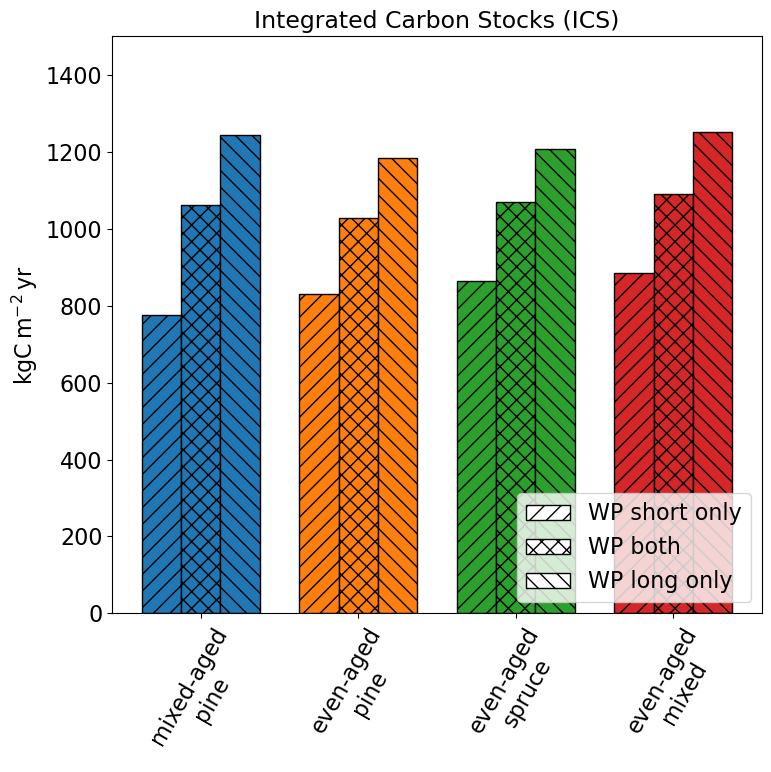

In [15]:
fig, ax = plt.subplots(figsize=(4*2, 4*2))

labels = [sim_name.replace("_", " ") for sim_name in sim_names]
colors = {
    'mixed-aged_pine': '#1f77b4',
    'even-aged_pine': '#ff7f0e',
    'even-aged_spruce': '#2ca02c',
    'even-aged_mixed': '#d62728'
}
hatches = ["//", "xx", "\\\\"]
width = 0.25
x = np.arange(len(sim_names))

multiplier = 0

for WP_nr, WP_type in enumerate(WP_types):
    offset = width * multiplier
#    rects = ax.bar(x + offset, cum_stocks_datas[-1, WP_nr, :], width, label=WP_type.replace("_", " "))
    rects = ax.bar(
        x + offset,
        cum_stocks_datas[-1, WP_nr, :], 
        width,
        color=[colors[sim_name] for sim_name in sim_names],
        edgecolor="black", hatch=hatches[WP_nr],
        label=WP_type.replace("_", " ")
    )
    multiplier += 1

#ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_ylim([0, 1500])
ax.set_title("Integrated Carbon Stocks (ICS)")
#ax.set_title("ICS")
ax.set_xticklabels("")
ax.legend(loc=4)

xlabels = [sim_name.replace("_", " ") for sim_name in sim_names]
xlabels = ["mixed-aged\npine", "even-aged\npine", "even-aged\nspruce", "even-aged\nmixed"]
ax.set_xticks(x + width, xlabels)

for tick in ax.get_xticklabels():
    tick.set_rotation(60)

leg = ax.get_legend()
for lh in leg.legend_handles:
    lh.set_color("white")
    lh.set_edgecolor("black")

fig.tight_layout()

filepath = pub_figs_path.joinpath("WP_spread_1_v2.png")
fig.savefig(filepath, dpi=500)
filepath

PosixPath('/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-11-23/WP_spread_2.png')

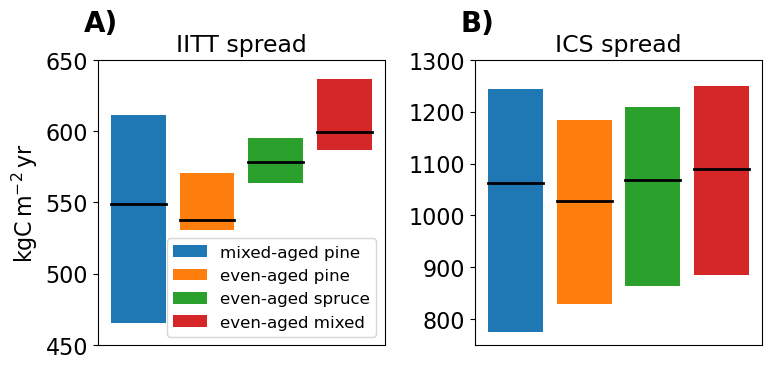

In [16]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
panel_names = iter(string.ascii_uppercase[:len(axes)])
axes = iter(axes)

ax = next(axes)
panel_name = next(panel_names)
#ax.set_title("Integrated Inputs Transit Time (IITT)")
ax.set_title("IITT spread")
#for WP_type_nr, WP_type in enumerate(WP_types):
width = 0.25
for nr, sim_name in enumerate(sim_names):   
#    ax.plot(CS_datas[:, WP_type_nr, nr], label=sim_name.replace("_", " "), c=colors[sim_name])
    bottom = CS_datas[-1, 0, nr]
    ax.bar(nr*width, height = CS_datas[-1, 2, nr] - bottom, bottom=bottom, width=width*0.8, label=sim_name.replace("_", " "))
#    print([nr*width-width/2, nr*width+width/2])
#    print([CS_datas[-1, 1, nr].magnitude]*2)
    ax.plot([nr*width-width/2*0.8, nr*width+width/2*0.8], [CS_datas[-1, 1, nr].magnitude]*2, c="black")

ax.set_ylim([450, 650])
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_xticks([])
ax.legend(loc=4, fontsize=12)


ax = next(axes)
panel_name = next(panel_names)
#ax.set_title("Integrated Inputs Transit Time (IITT)")
ax.set_title("ICS spread")
#for WP_type_nr, WP_type in enumerate(WP_types):
width = 0.25
for nr, sim_name in enumerate(sim_names):   
#    ax.plot(cum_stocks_datas[:, WP_type_nr, nr], label=sim_name.replace("_", " "), c=colors[sim_name])
    bottom = cum_stocks_datas[-1, 0, nr]
    ax.bar(nr*width, height = cum_stocks_datas[-1, 2, nr] - bottom, bottom=bottom, width=width*0.8, label=sim_name.replace("_", " "))
#    print([nr*width-width/2, nr*width+width/2])
#    print([cum_stocks_datas[-1, 1, nr].magnitude]*2)
    ax.plot([nr*width-width/2*0.8, nr*width+width/2*0.8], [cum_stocks_datas[-1, 1, nr].magnitude]*2, c="black")

ax.set_ylim([750, 1300])
#ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_ylabel("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_xticks([])

fig.tight_layout()

filepath = pub_figs_path.joinpath("WP_spread_2.png")
fig.savefig(filepath, dpi=500)
filepath